# H2O Uplift Distributed Random Forest 

### Author: Veronika Maurerova veronika.maurerova@h2o.ai

## Modeling Uplift 

Distributed Uplift Random Forest (Uplift DRF) is a classification tool for modeling uplift - the incremental impact of a treatment. This tool is very useful for example in marketing or in medicine. This machine learning approach is inspired by the A/B testing method. 

To model uplift, the analyst needs to collect data specifically - before the experiment, the objects are divided usually into two groups: 

- **treatment group**: receive some kind of treatment (for example customer get some type of discount) 
- **control group**: is separated from the treatment (customers in this group get no discount). 

Then the data are prepared and an analyst can gather information about the response - for example, whether customers bought a product, patients recovered from the disease, or similar. 

## Uplift approaches 

There are several approaches to model uplift: 

- Meta-learner algorithms
- Instrumental variables algorithms
- Neural-networks-based algorithms
- Tree-based algorithms 



## Tree Based Uplift Algorithm

Tree-based algorithm means in every tree, it takes information about treatment/control group assignment and information about response directly into a decision about splitting a node. The uplift score is the criterion to make a decision similar to the Gini coefficient in the standard decision tree. 

**Uplift metric to decide best split**

The goal is to maximize the differences between the class distributions in the treatment and control sets, so the splitting criteria are based on distribution divergences. The distribution divergence is calculated based on the ``uplift_metric`` parameter. In H2O-3, three ``uplift_metric`` types are supported:

- **Kullback-Leibler divergence** (``uplift_metric="KL"``) - uses logarithms to calculate divergence, asymmetric, widely used, tends to infinity values (if treatment or control group distributions contain zero values). 

$ KL(P, Q) = \sum_{i=0}^{N} p_i \log{\frac{p_i}{q_i}}$

- **Squared Euclidean distance** (``uplift_metric="euclidean"``) - symmetric and stable distribution, does not tend to infinity values. 

$ E(P, Q) = \sum_{i=0}^{N} \sqrt{p_i-q_i}$


- **Chi-squared divergence** (``uplift_metric="chi_squared"``) - Euclidean divergence normalized by control group distribution. Asymmetric and also tends to infinity values (if control group distribution contains zero values). 

$\sqrt{X}(P, Q) = \sum_{i=0}^{N} \frac{\sqrt{p_i-q_i}}{q_i}$

where:

- $P$ is treatment group distribution

- $Q$ is control group distribution

In a tree node the result value for a split is sum: $metric(P, Q) + metric(1-P, 1-Q)$. 

For the split gain value, the result within the node is normalized using a gini coefficient (Eclidean or ChiSquared) or entropy (KL) for each distribution before and after the split.


**Uplift score in each leaf is calculated as:**

- $TP = (TY1 + 1) / (T + 2)$
- $CP = (CY1 + 1) / (C + 2)$
- $uplift\_score = TP - CP $

where:
- $T$ how many observations in a leaf are from the treatment group (how many data rows in a leaf have ``treatment_column`` label == 1) 
- $C$ how many observations in a leaf are from the control group (how many data rows in the leaf have ``treatment_column`` label == 0)
- $TY1$ how many observations in a leaf are from the treatment group and respond to the offer (how many data rows in the leaf have ``treatment_column`` label == 1 and ``response_column`` label == 1)
- $CY1$ how many observations in a leaf are from the control group and respond to the offer (how many data rows in the leaf have ``treatment_column`` label == 0 and ``response_column`` label == 1)

**Note**: A higher uplift score means more observations from treatment group respond to the offer than from control group. Which means offered treatment has positive effect. The uplift score can be negative, if more observations from control group respond to the offer without treatment.

<br>
<br>

![Difference between SDT and Uplift DT](https://blog.h2o.ai/wp-content/uploads/2022/01/tree.png)




## H2O Implementation (Major release 3.36)

The H2O-3 implementation of Uplift DRF is based on DRF because the principle of training is similar to DRF. It is tree based uplift algorithm. Uplift DRF generates a forest of classification uplift trees, rather than a single classification tree. Each of these trees is a weak learner built on a subset of rows and columns. More trees will reduce the variance. Classification takes the average prediction over all of their trees to make a final prediction. 

Currently, in H2O-3 only binomial trees are supported, as well as the uplift curve metric and Area Under Uplift curve (AUUC) metric and the Qini coefficient. We are working on adding also regression trees and more metrics, for example, normalized AUUC, and more. 

## Start H2O-3

In [2]:
import h2o
from h2o.estimators.uplift_random_forest import H2OUpliftRandomForestEstimator

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style

import pandas as pd

In [3]:
h2o.init(strict_version_check=False)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 5 mins
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,mori
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4.359 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


## Load data

To demonstrate how Uplift DRF works, Criteo dataset is used. 

Source: https://www.kaggle.com/arashnic/uplift-modeling

**Description:**

- The dataset was created by The Criteo AI Lab
- Consists of 13M rows, each one representing a user with 12 features, a treatment indicator and 2 binary labels (visits and conversions).
- Positive labels mean the user visited/converted on the advertiser website during the test period (2 weeks).
- The global treatment ratio is 84.6%.

**Detailed description of the columns:**

- **f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11**: feature values (dense, float)
- **treatment**: treatment group (1 = treated, 0 = control)
- **conversion**: whether a conversion occured for this user (binary, label)
- **visit**: whether a visit occured for this user (binary, label)
- **exposure**: treatment effect, whether the user has been effectively exposed (binary)

In [4]:
control_name = "control"
treatment_column = "treatment"
response_column = "conversion"
feature_cols = ["f"+str(x) for x in range(0,12)]

df = pd.read_csv("../../smalldata/uplift/criteo_uplift.csv")
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


## Prepare data

Inspiration from: https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling/notebook

To modeling uplift the treatment and control group data have to have similar distribution. In real world usually the control group is smaller than the treatment group. It is also a case of Crieteo dataset and we have to rebalanced the data to have a similar size.

In [5]:
print('Total number of samples: {}'.format(len(df)))
print('The dataset is largely imbalanced: ')
print(df['treatment'].value_counts(normalize = True))
print('Percentage of users that visit: {}%'.format(100*round(df['visit'].mean(),4)))
print('Percentage of users that convert: {}%'.format(100*round(df['conversion'].mean(),4)))
print('Percentage of visitors that convert: {}%'.format(100*round(df[df["visit"]==1]["conversion"].mean(),4)))

Total number of samples: 13979592
The dataset is largely imbalanced: 
1    0.85
0    0.15
Name: treatment, dtype: float64
Percentage of users that visit: 4.7%
Percentage of users that convert: 0.29%
Percentage of visitors that convert: 6.21%


Class 0: 2096937
Class 1: 11882655
Proportion: 6 : 1


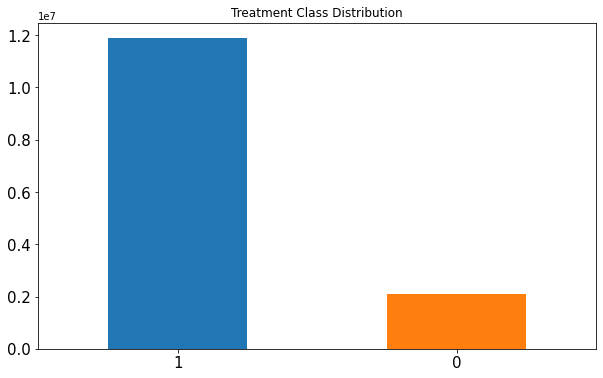

In [6]:
# Print proportion of a binary column
# https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling/notebook
def print_proportion(df, column):
    fig = plt.figure(figsize = (10,6))
    target_count = df[column].value_counts()
    print('Class 0:', target_count[0])
    print('Class 1:', target_count[1])
    print('Proportion:', int(round(target_count[1] / target_count[0])), ': 1')
    target_count.plot(kind='bar', title='Treatment Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
    plt.xticks(rotation=0) 
    
print_proportion(df, treatment_column)

In [7]:
from sklearn.model_selection import train_test_split
train_df, test_df  = train_test_split(df, test_size=0.2, random_state=42, stratify=df['treatment'])
print(train_df.shape)
print(test_df.shape)

(11183673, 16)
(2795919, 16)


In [8]:
del(df)

Class 0: 1677550
Class 1: 9506123
Proportion: 6 : 1


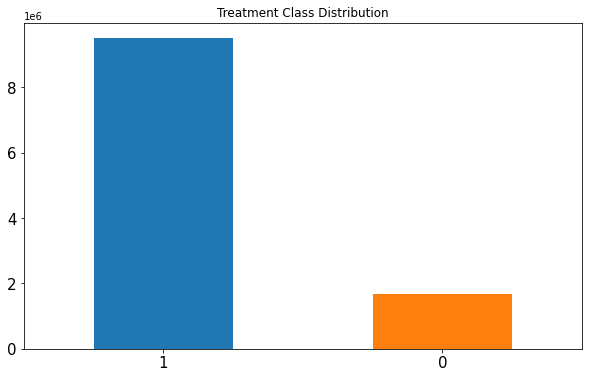

In [9]:
print_proportion(train_df, treatment_column)

In [10]:
# Random Undersampling (finding the majority class and undersampling it)
# https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling/notebook
def random_under(df, feature):
    
    target = df[feature].value_counts()
    
    if target.values[0]<target.values[1]:
        under = target.index.values[1]
    
    else: 
        under = target.index.values[0]
        
    df_0 = df[df[feature] != under]
    df_1 = df[df[feature] == under]
    
    df_treatment_under = df_1.sample(len(df_0))
    df_1 = pd.concat([df_treatment_under, df_0], axis=0)
    
    return df_1

In [11]:
train_df = random_under(train_df, treatment_column)

Class 0: 1677550
Class 1: 1677550
Proportion: 1 : 1


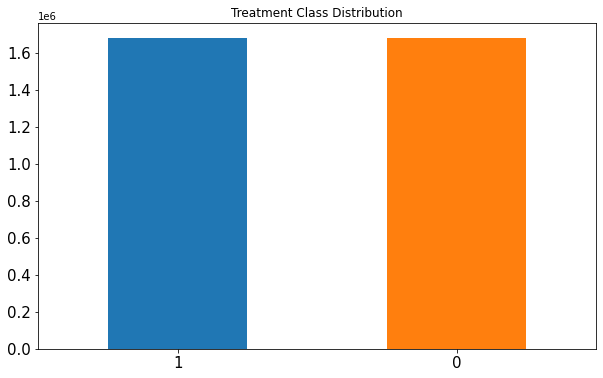

In [12]:
print_proportion(train_df, treatment_column)

## Import data to H2O

In [13]:
h2o_train_df = h2o.H2OFrame(train_df)
del(train_df)

h2o_train_df[treatment_column] = h2o_train_df[treatment_column].asfactor()
h2o_train_df[response_column] = h2o_train_df[response_column].asfactor()

h2o_test_df = h2o.H2OFrame(test_df)

h2o_test_df[treatment_column] = h2o_test_df[treatment_column].asfactor()
h2o_test_df[response_column] = h2o_test_df[response_column].asfactor()
del(test_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |██████████████████████████████████████████████████████████████████████████| (done) 100%


## Train H2O UpliftDRF model

In [14]:
ntree = 50
max_depth = 15
metric_h2o="Euclidean"

h2o_uplift_model = H2OUpliftRandomForestEstimator(
                    ntrees=ntree,
                    max_depth=max_depth,
                    min_rows=30,
                    nbins=1000,
                    sample_rate=0.80,
                    score_each_iteration=False,
                    treatment_column=treatment_column,
                    uplift_metric=metric_h2o,
                    auuc_nbins=1000,
                    auuc_type="gain",
                    seed=42)

h2o_uplift_model.train(y=response_column, x=feature_cols, training_frame=h2o_train_df)
h2o_uplift_model

upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Model Details
H2OUpliftRandomForestEstimator :  Uplift Distributed Random Forest
Model Key:  UpliftDRF_model_python_1649751884675_22


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,100.0,270228.0,15.0,15.0,15.0,134.0,316.0,211.0




ModelMetricsBinomialUplift: upliftdrf
** Reported on train data. **

AUUC: 3394.8084598058317
AUUC normalized: 0.8529669496999576

AUUC table (number of bins: 1000): All types of AUUC value


,uplift_type,qini,lift,gain
0,AUUC value,1713.454076,0.004063,3394.808460
1,AUUC normalized,0.861032,0.004063,0.852967
2,AUUC random value,995.994703,0.000594,1991.989406


Qini value: 717.4593723737117

AECU values table: All types of AECU value


,uplift_type,qini,lift,gain
0,AECU value,717.459372,0.003469,1402.819054



Scoring History: 


,,timestamp,duration,number_of_trees,training_auuc_nbins,training_auuc,training_auuc_normalized,training_qini_coefficient
0,,2022-04-12 11:32:39,0.040 sec,0.0,0,NaN,NaN,NaN
1,,2022-04-12 11:32:41,2.051 sec,1.0,9,3267.162878,0.820895,-16.633608
2,,2022-04-12 11:34:10,1 min 30.585 sec,50.0,1000,3394.808460,0.852967,717.459372


## Evaluate the model

In [15]:
perf_h2o = h2o_uplift_model.model_performance(h2o_test_df)



### Area Under Uplift Curve (AUUC) calculation

To calculate AUUC for big data, the predictions are binned to histograms. Due to this feature the results should be different compared to exact computation.

To define AUUC, binned predictions are sorted from largest to smallest value. For every group the cumulative sum of observations statistic is calculated. The uplift is defined based on these statistics.


#### Types of AUUC


| AUUC type | &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; Formula &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;|
|:----------:|:-------------------------------------------:|
| **Qini**   | $TY1 - CY1 * \frac{T}{C}$                   |
| **Lift**   | $\frac{TY1}{T} - \frac{CY1}{C}$             |
| **Gain**   | $(\frac{TY1}{T} - \frac{CY1}{C}) * (T + C)$ |


Where:

- **T** how many observations are in the treatment group (how many data rows in the bin have treatment_column label == 1)
- **C** how many observations are in the control group (how many data rows in the bin have treatment_column label == 0)
- **TY1** how many observations are in the treatment group and respond to the offer (how many data rows in the bin have treatment_column label == 1 and response_column label == 1)
- **CY1** how many observations are in the control group and respond to the offer (how many data rows in the bin have treatment_column label == 0 and response_column label == 1)


The resulting AUUC value is not normalized, so the result could be a positive number, but also a negative number. A higher number means better model. 

For some observation groups the results should be NaN. In this case, the results from NaN groups are linearly interpolated to calculate AUUC and plot uplift curve.


In [16]:
perf_h2o.auuc_table()


AUUC table (number of bins: 122): All types of AUUC value


,uplift_type,qini,lift,gain
0,AUUC value,2574.354786,0.003762,3021.908477
1,AUUC normalized,0.876628,0.003762,0.874676
2,AUUC random value,1826.316251,0.000768,2148.606585


### Cumulative Uplift curve plot

To plot the uplift curve, the ``plot_uplift``method can be used. There is specific parameter ``metric`` which can be ``"qini", "gain", or "lift"``. The most popular is the Qini uplift curve which is similar to the ROC curve. The Gain and Lift curves are also known from traditional binomial models. 

Depending on these curves, you can decide how many observations (for example customers) from the test dataset you send an offer to get optimal gain.

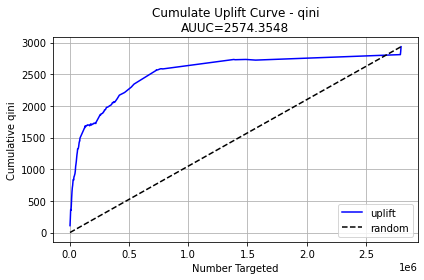

In [17]:
perf_h2o.plot_uplift(metric="qini")

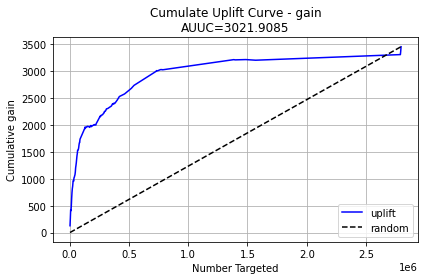

In [18]:
perf_h2o.plot_uplift(metric="gain")

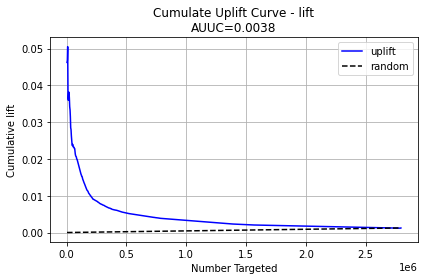

In [19]:
perf_h2o.plot_uplift(metric="lift")

### Qini value and AECU

Qini value is calculated as the difference between the Qini AUUC and area under the random uplift curve (random AUUC). The random AUUC is computed as diagonal from zero to overall gain uplift. 

The Qini value can be generalized for all AUUC metric types. So AECU for Qini metric is the same as Qini value, but the AECU can be also calculated for Gain and Lift metric type. These values are stored in ``aecu_table``.


In [20]:
perf_h2o.aecu_table()


AECU values table: All types of AECU value


,uplift_type,qini,lift,gain
0,AECU value,748.038535,0.002994,873.301891


### Normalized AUUC

To get normalized AUUC, you have to call ``auuc_normalized`` method. The normalized AUUC is calculated from uplift values which are normalized by uplift value from maximal treated number of observations. So if you have for example uplift values [10, 20, 30] the normalized uplift is [1/3, 2/3, 1]. If the maximal value is negative, the normalization factor is the absolute value from this number. The normalized AUUC can be again negative and positive and can be outside of (0, 1) interval. The normalized AUUC for ``auuc_metric="lift"`` is not defined, so the normalized AUUC = AUUC for this case. Also the ``plot_uplift`` with ``metric="lift"`` is the same for ``normalize=False`` and ``normalize=True``.


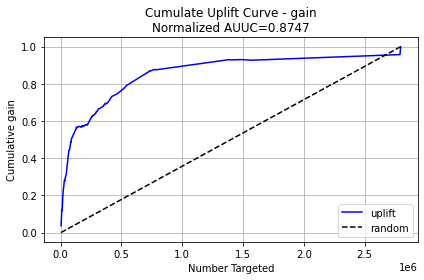

In [21]:
perf_h2o.plot_uplift(metric="gain", normalize=True)

In [22]:
perf_h2o.auuc_normalized()

0.8746762349475511

### Scoring histrory and importance of number of trees

To speed up the calculation of AUUC, the predictions are binned into quantile histograms. To calculate precision AUUC the more bins the better. The more trees usually produce more various predictions and then the algorithm creates histograms with more bins. So the algorithm needs more iterations to get meaningful AUUC results. 
You can see in the scoring history table the number of bins as well as the result AUUC. There is also Qini coefficient parameter, which reflects the number of bins and then is a better pointer of the model improvement. In the picture below you can see the algorithm stabilized after building 6 trees. But it depends on data and model settings on how many trees are necessary.

In [23]:
h2o_uplift_model.scoring_history()

,,timestamp,duration,number_of_trees,training_auuc_nbins,training_auuc,training_auuc_normalized,training_qini_coefficient
0,,2022-04-12 11:32:39,0.040 sec,0.0,0,NaN,NaN,NaN
1,,2022-04-12 11:32:41,2.051 sec,1.0,9,3267.162878,0.820895,-16.633608
2,,2022-04-12 11:34:10,1 min 30.585 sec,50.0,1000,3394.808460,0.852967,717.459372
